# Causal Data Science Project

Data from Card (1995) to estimate the effect of college education on earnings



In [1]:
pip install dowhy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 9.0 MB/s eta 0:00:00


Let's create a network and manually identify adjustment sets based on the backdoor criterion. We want to find effect of Education on wages
.

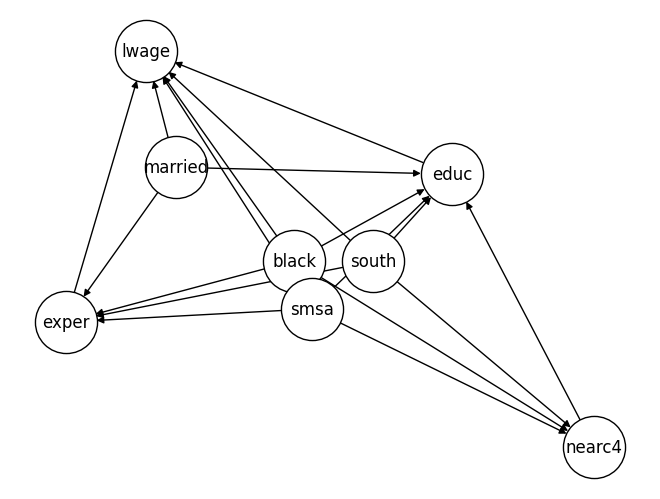

In [2]:
# we import networkx and create a directed graph
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(["lwage", "educ", "exper", "black", "south", "married", "smsa", "nearc4"])

G.add_edges_from([
    ("educ", "lwage"), ("exper", "lwage"),
    ("black", "lwage"), ("south", "lwage"), ("married", "lwage"), ("smsa", "lwage"),
    ("nearc4", "educ"),
    ("black", "educ"), ("south", "educ"), ("smsa", "educ"),
    ("married", "educ"),  # Additional pathway
    ("black", "exper"), ("south", "exper"), ("smsa", "exper"), ("married", "exper"),
    ("black", "nearc4"), ("south", "nearc4"), ("smsa", "nearc4"),
])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear)
# and save it to a .gml format (for using DoWhy later)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos= pos, with_labels=True, node_size=2000, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

We can start by identifying the descendants of Education, as these must <u>not</u> be in our adjustment set according to the backdoor criterion. The descendants of education are: eduaction and wages.

In [3]:
# this function finds the descendants of node 'X' in graph G
# note that in this function does not return 'X' as a descendant of 'X' - this is not the definition we use, so we add 'X'
nx.descendants(G,'educ') | {'educ'}

{'educ', 'lwage'}

We now consider every backdoor path from education to wages, and find the variables for which we can/must adjust. We start off by importing the 'backdoor' class from DoWhy.

In [4]:
# importing the backdoor class from DoWhy
from dowhy.causal_identifier import backdoor

Then, we create an undirected copy of our graph and call it $H$ so we can find all possible undirected paths between education and wages
.

In [5]:
# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [6]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
all_possible_paths = list(nx.all_simple_paths(H, 'educ', 'lwage'))
for path in all_possible_paths:
    print(path)

['educ', 'lwage']
['educ', 'black', 'lwage']
['educ', 'black', 'exper', 'lwage']
['educ', 'black', 'exper', 'south', 'lwage']
['educ', 'black', 'exper', 'south', 'nearc4', 'smsa', 'lwage']
['educ', 'black', 'exper', 'married', 'lwage']
['educ', 'black', 'exper', 'smsa', 'lwage']
['educ', 'black', 'exper', 'smsa', 'nearc4', 'south', 'lwage']
['educ', 'black', 'nearc4', 'south', 'lwage']
['educ', 'black', 'nearc4', 'south', 'exper', 'lwage']
['educ', 'black', 'nearc4', 'south', 'exper', 'married', 'lwage']
['educ', 'black', 'nearc4', 'south', 'exper', 'smsa', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'exper', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'exper', 'south', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'exper', 'married', 'lwage']
['educ', 'south', 'lwage']
['educ', 'south', 'exper', 'lwage']
['educ', 'south', 'exper', 'black', 'lwage']
['educ', 'south', 'exper', 'black', 'nearc4', 'smsa', 'lwage']
['educ', 'south', 'exper', 'm

Finally, we can use the `is_backdoor` method of a `Backdoor` instance to check which of these paths are backdoor paths.

In [7]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'educ', 'lwage')

In [8]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['educ', 'black', 'lwage']
['educ', 'black', 'exper', 'lwage']
['educ', 'black', 'exper', 'south', 'lwage']
['educ', 'black', 'exper', 'south', 'nearc4', 'smsa', 'lwage']
['educ', 'black', 'exper', 'married', 'lwage']
['educ', 'black', 'exper', 'smsa', 'lwage']
['educ', 'black', 'exper', 'smsa', 'nearc4', 'south', 'lwage']
['educ', 'black', 'nearc4', 'south', 'lwage']
['educ', 'black', 'nearc4', 'south', 'exper', 'lwage']
['educ', 'black', 'nearc4', 'south', 'exper', 'married', 'lwage']
['educ', 'black', 'nearc4', 'south', 'exper', 'smsa', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'exper', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'exper', 'south', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'exper', 'married', 'lwage']
['educ', 'south', 'lwage']
['educ', 'south', 'exper', 'lwage']
['educ', 'south', 'exper', 'black', 'lwage']
['educ', 'south', 'exper', 'black', 'nearc4', 'smsa', 'lwage']
['educ', 'south', 'exper', 'married', 'lwage']


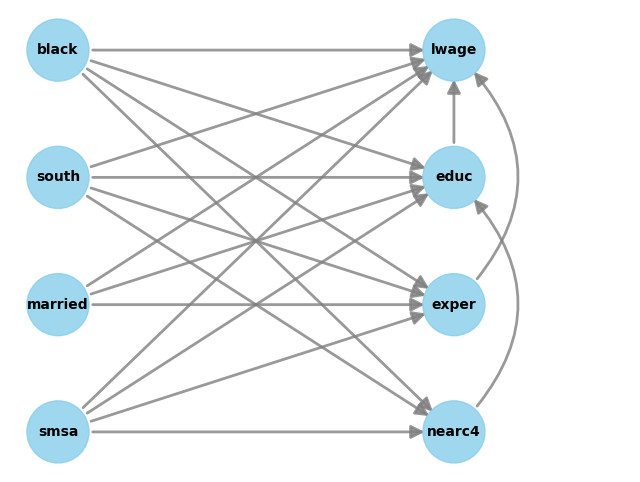

In [10]:
import dowhy
from dowhy import CausalModel
import pandas as pd

# creating arbitrary data
df = pd.DataFrame({'lwage':[1],'educ':[1],'exper':[1],'black':[1],'south':[1],'married':[1],
                  'smsa': [1], 'nearc4': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
    data = df,
    treatment='educ',
    outcome='lwage',
    graph=gml_graph
)
model.view_model()

In [11]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                      
───────(E[lwage|south,black,married,smsa])
d[educ]                                   
Estimand assumption 1, Unconfoundedness: If U→{educ} and U→lwage then P(lwage|educ,south,black,married,smsa,U) = P(lwage|educ,south,black,married,smsa)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



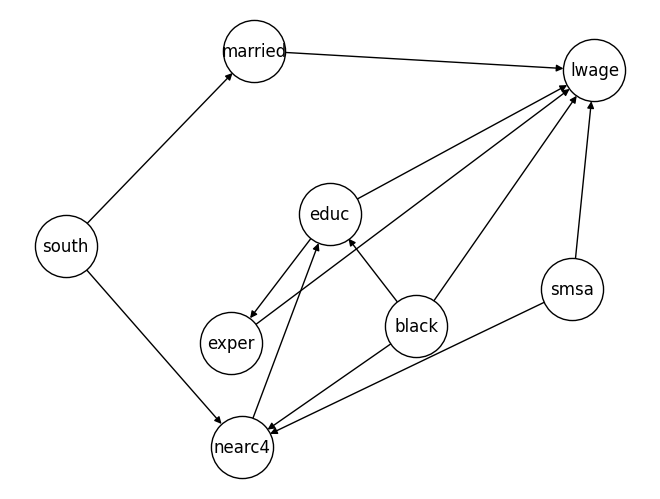

In [12]:
# we import networkx and create a directed graph
import networkx as nx
G = nx.DiGraph()

G.add_nodes_from(["lwage", "educ", "exper", "black", "south", "married", "smsa", "nearc4"])

G.add_edges_from([
    ("educ", "lwage"), ("exper", "lwage"),
    ("black", "lwage"), ("south", "married"), ("married", "lwage"),
    ("nearc4", "educ"),
    ("black", "educ"), ("south", "nearc4"),
    ("married", "lwage"),
    ("black", "nearc4"), ("smsa", "nearc4"), ("smsa", "lwage"), ("educ", "exper")
])

# we can visualise this graph (choosing node positions, colours, and sizes to make it more clear)
# and save it to a .gml format (for using DoWhy later)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos= pos, with_labels=True, node_size=2000, node_color='w', edgecolors ='black')
nx.write_gml(G, "backdoor_criterion_graph.gml")

In [13]:
# this function finds the descendants of node 'X' in graph G
# note that in this function does not return 'X' as a descendant of 'X' - this is not the definition we use, so we add 'X'
nx.descendants(G,'educ') | {'educ'}

{'educ', 'exper', 'lwage'}

In [14]:
# creating a copy of our graph G that is undirected
H = G.to_undirected()

In [15]:
# the all_simple_paths function finds all possible undirected paths between 'X' and 'Y' in graph H
all_possible_paths = list(nx.all_simple_paths(H, 'educ', 'lwage'))
for path in all_possible_paths:
    print(path)

['educ', 'lwage']
['educ', 'exper', 'lwage']
['educ', 'black', 'lwage']
['educ', 'black', 'nearc4', 'south', 'married', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'lwage']
['educ', 'nearc4', 'black', 'lwage']
['educ', 'nearc4', 'south', 'married', 'lwage']
['educ', 'nearc4', 'smsa', 'lwage']


In [16]:
# we can create a Backdoor object with G, 'X', and 'Y'
# note that we are back to using the directed graph, G, as we only needed the undirected to find the paths
bd = backdoor.Backdoor(G, 'educ', 'lwage')

In [17]:
# we apply the is_backdoor function to each path to check if a path is a backdoor path
backdoor_paths = [path for path in all_possible_paths if bd.is_backdoor(path)]
for path in backdoor_paths:
    print(path)

['educ', 'black', 'lwage']
['educ', 'black', 'nearc4', 'south', 'married', 'lwage']
['educ', 'black', 'nearc4', 'smsa', 'lwage']
['educ', 'nearc4', 'black', 'lwage']
['educ', 'nearc4', 'south', 'married', 'lwage']
['educ', 'nearc4', 'smsa', 'lwage']


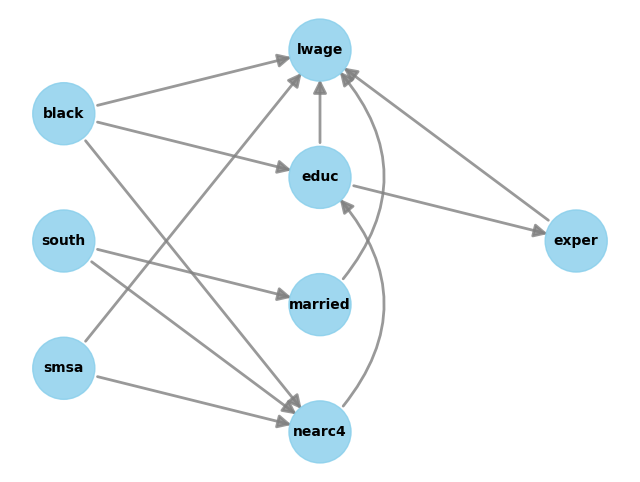

In [18]:
import pandas as pd
import dowhy
from dowhy import CausalModel

# creating arbitrary data
df = pd.DataFrame({'lwage':[1],'educ':[1],'exper':[1],'black':[1],'south':[1],'married':[1],
                  'smsa': [1], 'nearc4': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
    data = df,
    treatment='nearc4',
    outcome='lwage',
    graph=gml_graph
)
model.view_model()

In [19]:
identified_estimand = model.identify_effect()
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                 
─────────(E[lwage|married,smsa,black])
d[nearc₄]                             
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,married,smsa,black,U) = P(lwage|nearc4,married,smsa,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



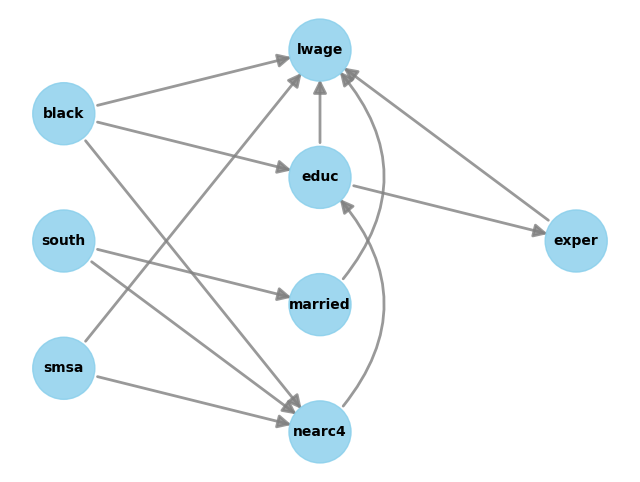

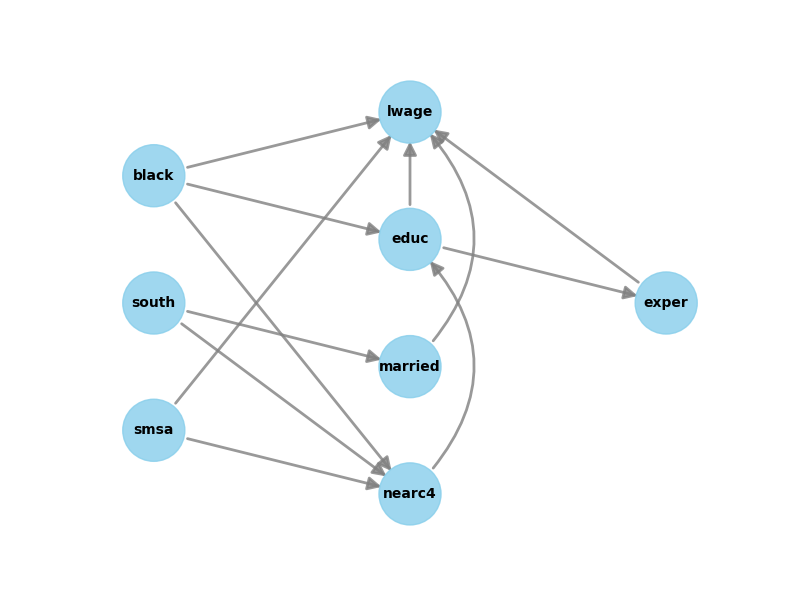

In [29]:
import dowhy
import pandas as pd
from dowhy import CausalModel

# once again we use arbitrary data, since we are still focused on the graph and not data
df = pd.DataFrame({'lwage':[1],'educ':[1],'exper':[1],'black':[1],'south':[1],'married':[1],
                  'smsa': [1], 'nearc4': [1]})

# a utility function to parse the .gml file to string
def gml_to_string(file):
    gml_str = ''
    with open(file, 'r') as file:
        for line in file:
            gml_str += line.rstrip()
    return gml_str

from IPython.display import Image, display

gml_graph = gml_to_string('backdoor_criterion_graph.gml')
# With GML string
model=CausalModel(
        data = df,
        treatment='nearc4',
        outcome='lwage',
        graph=gml_graph
        )
model.view_model()

display(Image(filename="causal_model.png", width = 200, height = 100))

In [30]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                 
─────────(E[lwage|married,smsa,black])
d[nearc₄]                             
Estimand assumption 1, Unconfoundedness: If U→{nearc4} and U→lwage then P(lwage|nearc4,married,smsa,black,U) = P(lwage|nearc4,married,smsa,black)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [37]:
from google.colab import drive
import torch
drive.mount('/content/drive')
import os
os.chdir('/content/drive/MyDrive')
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
'Academic English Assignment 2 .gdoc'
'Advanced Programming.gdoc'
'AML PROJECT'
'Analysing the introduction (1)-1.gdoc'
'Analysing the introduction (1)-1.pages'
'Assignment 1  Business Simulation.gdoc'
'Assignment 2 Business simulation.gdoc'
'Assignment 3 Business Simulation.gdoc'
'Assignment 4 Business Simulation.gdoc'
'Assignment 7.gdoc'
'Assignment A.gdoc'
'Assignment self-reflection.gdoc'
'Assignment week 5.gdoc'
 Big_Data_G_18
'Big Data.gdoc'
 Brief.gdoc
'Bullet Point draft.gdoc'
'Caroliens stomme debat.gdoc'
 Casual_data.ipynb
'Character development essay.gdoc'
 Character-Development-Worksheet.pdf
'Checklist FINAL version INTRODUCTION Moves123-2.gdoc'
'Checklist FINAL version INTRODUCTION Moves123-2.pdf'
 close_college.dta
'Cohesion exercise table-session 3.gdoc'
'Colab Notebooks'
 Combined_data.pkl
'Consultancyvoorstel (1).gslides'
 Consultancyvoorstel

In [38]:
close_college = pd.read_stata('close_college.dta')

In [44]:
close_college

,nearc4,educ,black,smsa,south,married,exper,lwage
0,0,7,1,1,0,1.0,16,6.306275
1,0,12,0,1,0,1.0,9,6.175867
2,0,12,0,1,0,1.0,16,6.580639
3,1,11,0,1,0,1.0,10,5.521461
4,1,12,0,1,0,1.0,16,6.591674
...,...,...,...,...,...,...,...,...
3005,1,12,0,0,1,1.0,7,5.814130
3006,1,13,0,1,1,1.0,15,6.175867
3007,1,12,0,0,1,1.0,6,6.214608
3008,1,12,0,0,1,1.0,13,6.569481


In [48]:
# we use the data and the graph it is generated from to create a CausalModel object
model=CausalModel(
        data = close_college,
        treatment=close_college["nearc4"],
        outcome=close_college["lwage"],
        graph=gml_graph
        )

model.view_model()
display(Image(filename="causal_model.png"))

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# we first use only v0 and y
# we need to reshape them into the correct shape for our linear regression function
nearc4_vals = df['nearc4'].values.reshape(3010, 1)
lwage_vals = df['lwage'].values.reshape(3010, 1)